This is the most step-by-step spelled-out explanation of backpropagation and training of neural networks. It only assumes basic knowledge of Python and a vague recollection of calculus from high school.


In [2]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from graphviz import Digraph

%matplotlib inline

## 1. Revision of derivatives

In [3]:
def f(x):
    return 3*x**2 - 4*x + 5

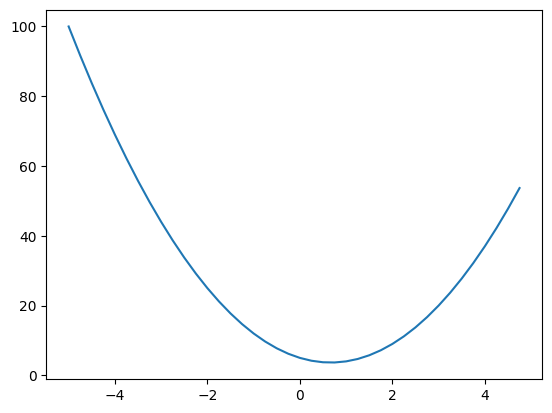

In [4]:
xs = np.arange(-5,5,0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
# Derivative
h = 0.000001
x = 0.0
(f(x+h)-f(x))/h

-3.99999700029241

In [6]:
# More complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
d

4.0

In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
a += h # increment a
d2 = a*b+c # a increases, but b is negative, so we actually reduce d2

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [8]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
b += h # increment a
d2 = a*b+c # b increases, and a is positive, so we actually increase d2

print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b+c
c += h # increment a
d2 = a*b+c # d scales linearly with c, slope should be = 1
print('d1', d1)
print('d2', d2)
print('slope', (d2-d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


## 2. Nodes and Layers

In [10]:
class Value:
    def __init__(self, data, _children = (), _op='', label=''):
        self.data = data
        self.grad = 0.0 # gradient = 0 means changes in its value does not affect the output
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            # Gradient needs to be accumulated - Multivariate Chain Rule
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            # Gradient needs to be accumulated - Multivariate Chain Rule
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other): # other * self for reverse multiplication
        return self * other
    
    def __pow__(self, other): # self**other
        assert isinstance(other, (int, float)) # only support int/float powers for now
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other*self.data**(other-1) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __neg__(self): # -self
        return self * -1
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            # Gradient needs to be accumulated - Multivariate Chain Rule
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out
    
    def backward(self):
        # Topological Sort - all the edges going one way from left to right, starting from the root node
        topo = []
        visited = set() # maintain the visited nodes
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self) # start from the root node
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [11]:
def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

### Back propagation
- Recursive operation of Chain rule
- Calculation of gradient of each weight w.r.t loss function L using Chain rule

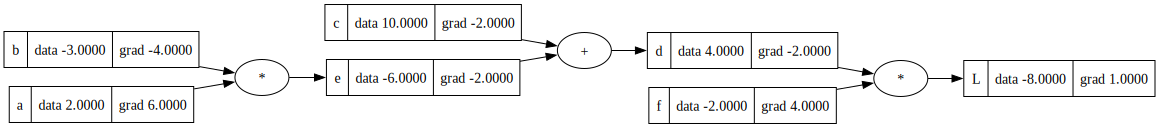

In [198]:
# Dummay function to verify the derivative of L w.r.t different input variables
# Original L1
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label='d'
f = Value(-2.0, label='f')
L = d * f; L.label='L'
L.backward()
draw_dot(L)
    # L1 = L.data

    # # Slightly nudged L2
    # a = Value(2.0, label='a')
    # b = Value(-3.0, label='b')
    # b.data += h

    # c = Value(10.0, label='c')
    # e = a*b; e.label = 'e'
    # d = e + c; d.label='d' # dd/dc = 1 & dd/de = 1
    # f = Value(-2.0, label='f');  
    # # d.data += h
    # L = d * f; L.label='L'
    # L2 = L.data

    # print((L2-L1)/h)

*dL/dc = dL/dd * dd/dc through Chain rule*

*dL/de = dL/dd * dd/de through Chain rule*

*dL/da = dL/dd * dd/de * de/da through Chain rule*

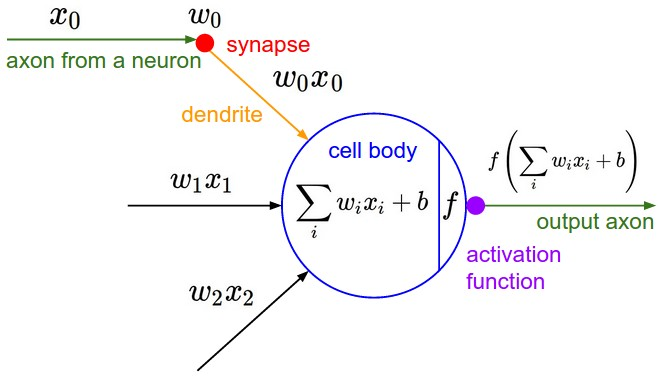

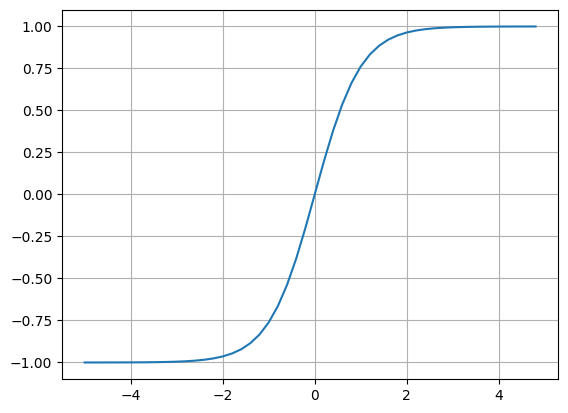

In [81]:
# Example of activation functions
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid()

### Using tanh()

In [12]:
# Input x1, x2 - 2-D neurons
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights of neurons w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.88137358870195432, label='b')
# Summation of neurons and adding bias
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Apply activation function
o = n.tanh(); o.label = 'o'

# increasing the bias b will squash output o based on the activation function tanh()


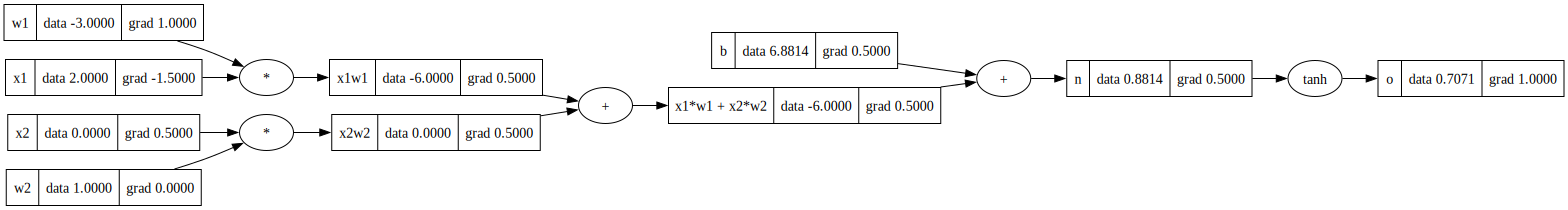

In [13]:
# Back propagration - Calling the backward() 
# AUTOMATIC calculation of the grads
o.backward()
draw_dot(o)

### Using atomic expression of tanh()
tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)

In [14]:
# Using atomic expression of tanh()
# Input x1, x2 - 2-D neurons
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# Weights of neurons w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# Bias of the neuron
b = Value(6.88137358870195432, label='b')
# Summation of neurons and adding bias
x1w1 = x1 * w1; x1w1.label = 'x1w1'
x2w2 = x2 * w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

# Apply activation function
e = (2*n).exp()
o = (e - 1)/(e + 1); o.label = 'o'

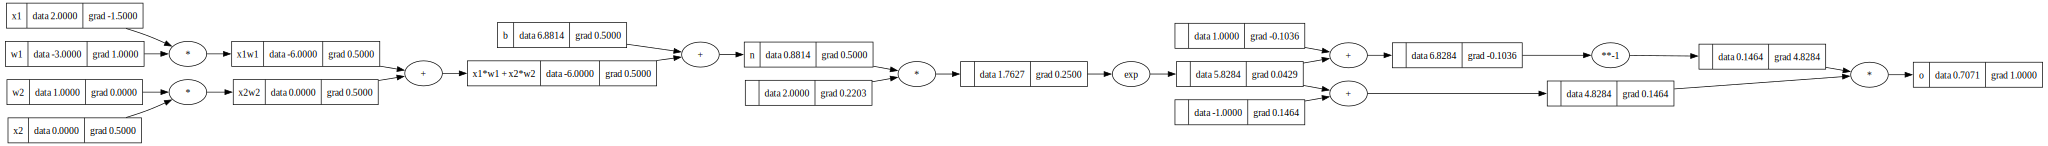

In [15]:
o.backward()
draw_dot(o)

In [16]:
# Back propagation - more specifically on w1 and w2, which can be tuned
# REMINDER - This is only one small neuron. In practice there are many more neurons
# STEP BY STEP CALCULATION
o.grad = 1.0 # do/do

n.grad = 1 - o.data**2 # o = tanh(n) --> do/dn = 1 - (tanh(n))**2 = 1 - o**2
b.grad = n.grad # do/db = do/dn * dn/db = n.grad * 1.0 = n.grad
x1w1x2w2.grad = n.grad # similar to b.grad

x1w1.grad = x1w1x2w2.grad # do/dx1w1 = do/dn * dn/dx1w1x2w2 * dx1w1x2w2/dx1w1 = do/dn * 1.0 * 1.0
x2w2.grad = x1w1x2w2.grad

x1.grad = x1w1.grad * w1.data
x2.grad = x2w2.grad * w2.data
w1.grad = x1w1.grad * x1.data
w2.grad = x2w2.grad * x2.data

In [17]:
# Back propagration - Calling the backward() in proper order
# MANUAL using functions defined in Class Value
# Base case
o.grad = 1.0
# Recursive
o._backward()
n._backward()
b._backward() # nothing happens as it is a leaf node
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

### Using Pytorch
to realize the same loss function and gradients

In [18]:
import torch

In [19]:
# cast to double() to be similar to Python. use dtype to check type

x1 = torch.Tensor([2.0]).double();                              x1.requires_grad = True
x2 = torch.Tensor([0.0]).double();                              x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double();                             w1.requires_grad = True
w2 = torch.Tensor([1.0]).double();                              w2.requires_grad = True

b = torch.Tensor([6.88137358870195432]).double();               b.requires_grad = True
n = x1*w1 + x2*w2 + b

o = torch.tanh(n)

print(o.data.item()) # forward pass
o.backward()         # back propagation
print('-----')
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

0.7071066904050358
-----
x1 -1.5000003851533106
x2 0.5000001283844369
w1 1.0000002567688737
w2 0.0


## 3. Building neural network

### Neurons & Layers

Neuron

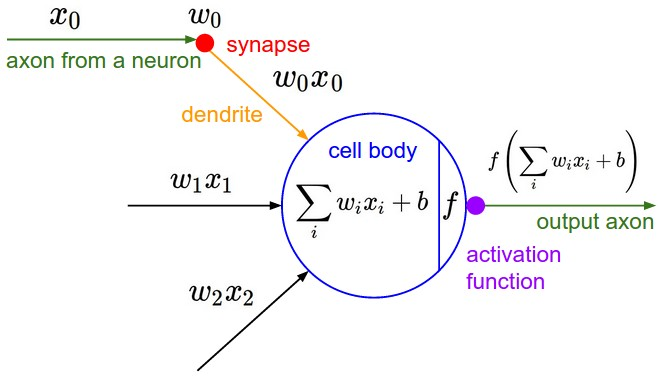

In [57]:
from typing import Any


class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)] # nin = no. of inputs to neuron
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # Implement w * x + b
        act = Value(0.0)
        for wi, xi in zip(self.w, x):
            act += wi*xi
        act += self.b
        # act = sum(wi*xi for wi, xi in zip(self.w, x))
        out = act.tanh()
        # zip function pairs elements of 2 arrays at the same position and create a tuple
        # list(zip([1,2], [3,4])) == [(1,3), (2,4)] # true
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout): # nin = no. of inputs to each neuron; nout = no. of neurons in a single layer
        self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
    
class MLP:

    def __init__(self, nin, nouts): # nouts = list of size of each layer
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
    

In [217]:
x = [2.0, 3.0, -1.0] 
n = MLP(3, [4, 4, 1]) # 3 neurons at input layer, 4 neurons at each hidden layer, and 1 neuron at output layer
n(x)

Value(data=-0.9135046356702622)

In [60]:
len(n.parameters())

41

MLP

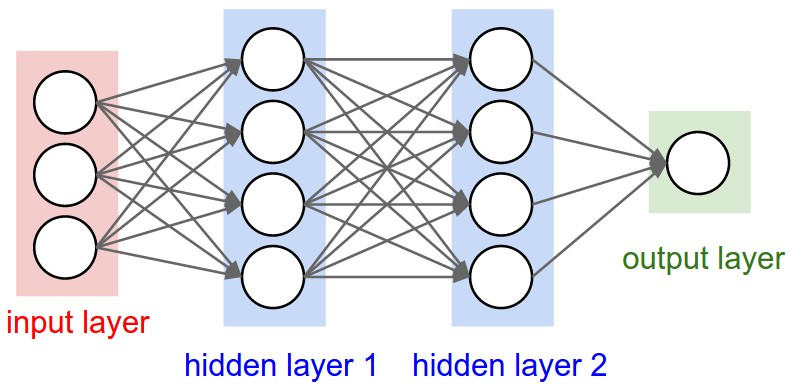

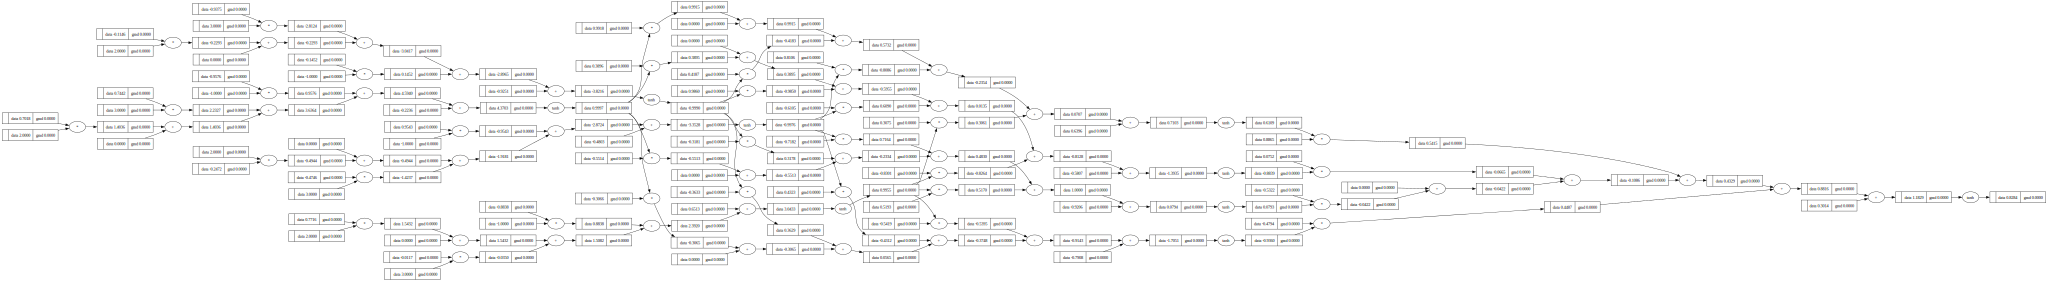

In [61]:
draw_dot(n(x))

### Define loss function

In [215]:
# Example
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets for each 3-dimensional xs inputs - binary classifier

#### Manual training

In [ ]:
# Define MLP
n = MLP(3, [4, 4, 1]) # 3 neurons at input layer, 4 neurons at each hidden layer, and 1 neuron at output layer

In [63]:
# Define mean squared loss
ypred = [n(x) for x in xs]
loss = Value(0.0)
for ygt, yout in zip(ys, ypred): # ygt = y ground truth
    loss += (yout-ygt)**2 
loss

Value(data=6.430601891387839)

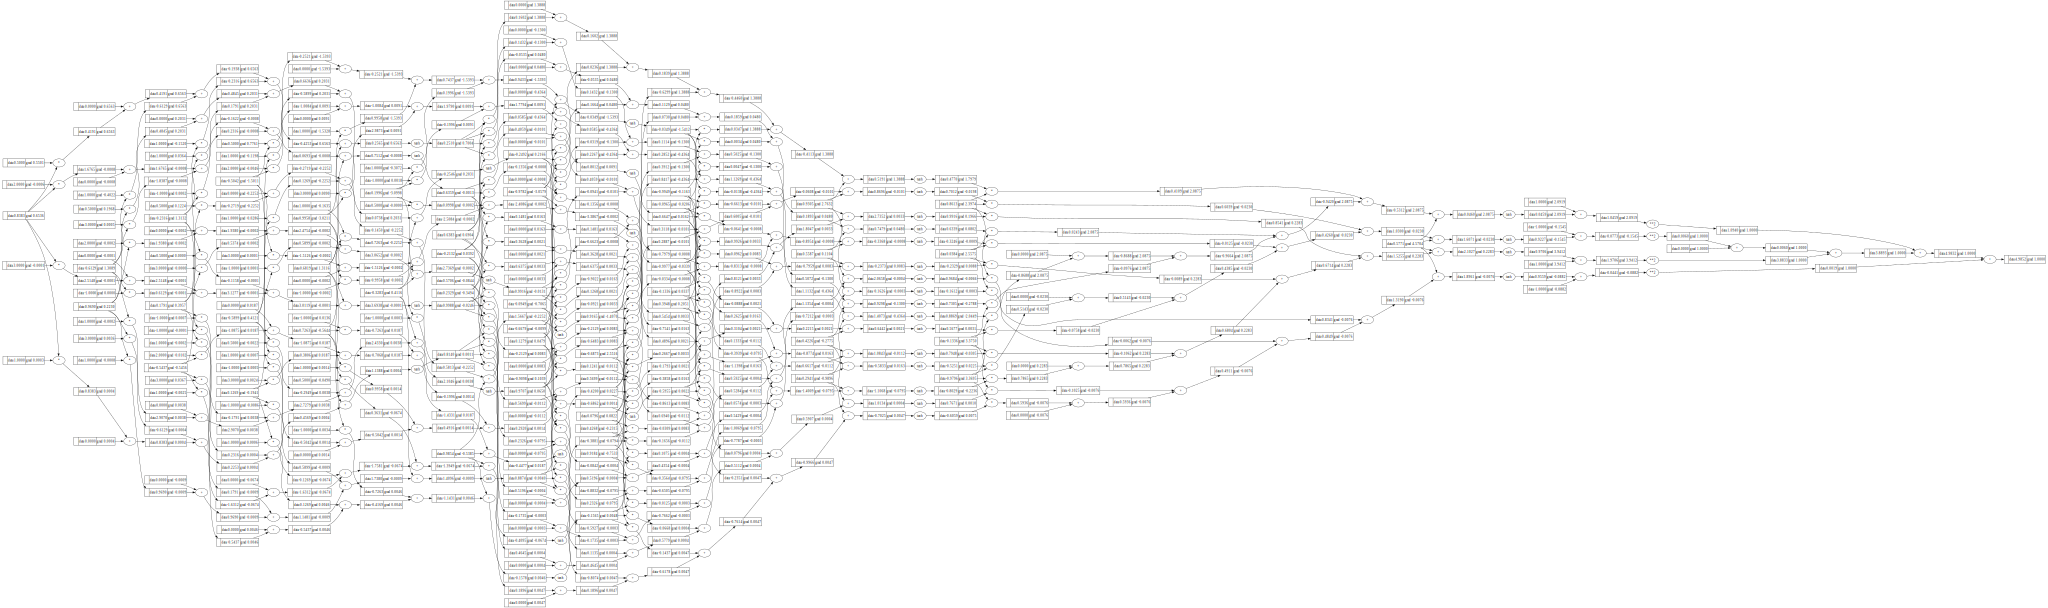

In [56]:
draw_dot(loss)
# inputs include input data, weights & biases
# grad for input data is not meaningful as input data do not generally change
# only grad for weights and biases are important for tuning

In [70]:
n.layers[0].neurons[0].w[0].data

0.683223795698897

In [203]:
STEP_SIZE = 0.05 # Learning rate
for p in n.parameters():
    p.data += -STEP_SIZE * p.grad # negative sign to decrease the loss by going in the opposite direction

In [204]:
# Re-calculate the loss (forward pass) after updating the parameters
ypred = [n(x) for x in xs]
loss = Value(0.0)
for ygt, yout in zip(ys, ypred): # ygt = y ground truth
    loss += (yout-ygt)**2 
loss

Value(data=8.927853349119831e-08)

In [205]:
loss.backward()

In [206]:
ypred

[Value(data=0.9997920656180953),
 Value(data=-0.9999880119455838),
 Value(data=-0.9999999525400703),
 Value(data=0.9997857615566431)]

In [209]:
n.parameters() # setting of weights and bias for loss minimization

[Value(data=-0.6432200518517373),
 Value(data=0.3234212240510937),
 Value(data=-3.506517521570862),
 Value(data=-1.7498121793265542),
 Value(data=-1.565357177861279),
 Value(data=-0.3833022518293515),
 Value(data=-0.5928133323031541),
 Value(data=-1.395476811694973),
 Value(data=-1.4019358019112522),
 Value(data=-1.442993958285482),
 Value(data=-0.3508707884614822),
 Value(data=-1.8396987590920715),
 Value(data=0.44701383254999366),
 Value(data=-0.43605421747308953),
 Value(data=-1.3568122083829908),
 Value(data=0.16281527134772308),
 Value(data=-1.514369381591157),
 Value(data=-0.11542472477292522),
 Value(data=0.0479419636100645),
 Value(data=-0.13305975345685525),
 Value(data=-0.9926473017401681),
 Value(data=1.0226919508129988),
 Value(data=0.6873905693935686),
 Value(data=-0.9161040224134698),
 Value(data=-0.40408108609250315),
 Value(data=-0.2996202949409761),
 Value(data=3.6043005210446566),
 Value(data=-0.07983300779811316),
 Value(data=-0.6734309733864213),
 Value(data=1.68840

#### Automatic Training

In [225]:
# Define MLP
n = MLP(3, [4, 4, 1]) # 3 neurons at input layer, 4 neurons at each hidden layer, and 1 neuron at output layer

In [251]:
ITERATION = 20
STEP_SIZE = 1 # Learning rate

for k in range(ITERATION):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = Value(0.0)
    for ygt, yout in zip(ys, ypred): # ygt = y ground truth
        loss += (yout-ygt)**2 
    
    # backward pass
    # zero grad
    for p in n.parameters():
        p.grad = 0.0 # reset zero grad so the backward pass won't keep adding the grad between each iteration
    loss.backward() # calculate the grad i.e., sensitivity of each parameters

    # update - gradient descent
    for p in n.parameters():
        p.data += -STEP_SIZE * p.grad # negative sign to decrease the loss by going in the opposite direction

    print(k, loss.data)      

0 0.00010068462041560883
1 0.00010013846629053954
2 9.959811967760358e-05
3 9.906348888544856e-05
4 9.853448413833075e-05
5 9.80110175264063e-05
6 9.749300295757812e-05
7 9.698035611080231e-05
8 9.647299439085938e-05
9 9.59708368844729e-05
10 9.547380431777685e-05
11 9.498181901504765e-05
12 9.449480485870866e-05
13 9.401268725049056e-05
14 9.353539307376952e-05
15 9.3062850657015e-05
16 9.259498973831115e-05
17 9.213174143092005e-05
18 9.167303818983613e-05
19 9.121881377934971e-05


In [252]:
ypred

[Value(data=0.9952283660827095),
 Value(data=-0.9971944164139798),
 Value(data=-0.9945119854966665),
 Value(data=0.9944808767823351)]